# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# For data preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# For classification model
# 'lr', 'rf', 'lightgbm', 'gbc', 'xgboost'
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier

# For deep learning model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC

# For evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import shap

In [2]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)
# Ignore warnings
warnings.filterwarnings('ignore')


In [3]:
# set the working directory
os.chdir('C:\\Users\\h2408\\Downloads\\RA\\1_paper_LASI\\data')

# Data Preparation

In [4]:
# Load data
data = pd.read_csv("derived_df.csv")

# Drop the target variables of other papers
target_vars = ['bmi_underweight', 'bmi_overweight', 'waist_circumference']
######################################
target_var = 'bmi_overweight'
######################################
data.shape

(64867, 80)

In [5]:
category_col = [
    'education',
    'state',
    'region',
    'religion',
    'MPCE',
    'working_status',
    'occupation',
    'caste',
    'water',
    'alcohol',
    'activity1',
    'benefit'
    ]

# Convert Type
for col in data.columns:
  if col in category_col:
    data[col] = data[col].astype('category')
  else:
    data[col] = data[col].astype('float')

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64867 entries, 0 to 64866
Data columns (total 80 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  64867 non-null  float64 
 1   gender               64867 non-null  float64 
 2   education            64866 non-null  category
 3   migration            64770 non-null  float64 
 4   state                64867 non-null  category
 5   region               64867 non-null  category
 6   residence            64867 non-null  float64 
 7   religion             64867 non-null  category
 8   martial_status       64865 non-null  float64 
 9   living_alone         64867 non-null  float64 
 10  MPCE                 64865 non-null  category
 11  working_status       64852 non-null  category
 12  occupation           64867 non-null  category
 13  pension_amount       64867 non-null  float64 
 14  retired              64774 non-null  float64 
 15  pension            

In [7]:
used_data = data.copy()
# Drop the missing values
used_data = used_data.dropna()
# Define X and y
X = used_data.drop(target_vars, axis=1)
y = used_data[target_var]
X.shape, y.shape

((55647, 77), (55647,))

In [8]:
groups = {
        'Overall': slice(None),
        'Scheduled Caste': X['caste'] == 'Scheduled caste',
        'Scheduled Tribe': X['caste'] == 'Scheduled tribe',
        'General': X['caste'] == 'General',
        'Other Backward Class': X['caste'] == 'Other backward class',
        'MPCE 1': X['MPCE'] == 'Lowest',
        'MPCE 2': X['MPCE'] == 'Lower middle',
        'MPCE 3': X['MPCE'] == 'Middle',
        'MPCE 4': X['MPCE'] == 'Upper middle',
        'MPCE 5': X['MPCE'] == 'Highest',
    }

In [9]:
# Category encoding
X = pd.get_dummies(X)
# dummy_col = ['education_No', 'state_Chandigarh', 'region_Central', 'religion_Others', 'MPCE_Middle', 'working_status_Never worked', 'occupation_Currently no work', 'caste_General', 'water_other', 'alcohol_abstainer', 'activity1_moderate', 'benefit_non-applicable']
# dummy_col = ['education_No', 'state_Chandigarh', 'region_Central', 'religion_Others', 'working_status_Never worked', 'occupation_Currently no work', 'water_other', 'alcohol_abstainer', 'activity1_moderate', 'benefit_non-applicable']
# X = X.drop(dummy_col, axis=1)
X.shape

(55647, 141)

In [10]:
X = X.astype('float32')
y = y.astype('float32')

# Standardization
scaler = StandardScaler()
X_sd = scaler.fit_transform(X)
X = pd.DataFrame(X_sd, columns=X.columns, index=X.index)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((44517, 141), (11130, 141))

# Functions

In [11]:
# Function: Define the function to create the DNN model
def create_dnn_model(dim):
    model = Sequential()
    model.add(Dense(128, input_dim=dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # For binary classification

    # Compile the model with AUROC as a metric
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auroc')])
    return model

In [12]:
# Function: Define the function to create the Fully Connected Network (FCN) model
def create_fcn_model(dim):
    model = Sequential()
    model.add(Dense(128, input_dim=dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # For binary classification

    # Compile the model with AUROC as a metric
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auroc')])
    return model

# Models

In [13]:
# #logistic regression
# model_lr = LogisticRegression(max_iter=1000, random_state=42)
# model_lr.fit(X_train, y_train)

# #random forest
# model_rf = RandomForestClassifier(random_state=42)
# model_rf.fit(X_train, y_train)

# #XGBoost
# model_xgb = XGBClassifier(eval_metric='logloss', random_state=42)
# model_xgb.fit(X_train, y_train)

# #gradient boosting
# model_gb = GradientBoostingClassifier(random_state=42)
# model_gb.fit(X_train, y_train)

#lightGBM
model_lgbm = LGBMClassifier(random_state=42, force_row_wise=True, verbose=-1)
model_lgbm.fit(X_train, y_train)

LGBMClassifier(force_row_wise=True, random_state=42, verbose=-1)

In [14]:
# #DNN
# model_dnn = create_dnn_model(X_train.shape[1])
# model_dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auroc')])
# model_dnn.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

In [15]:
# #FCN
# model_fcn = create_fcn_model(X_train.shape[1])
# model_fcn.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auroc')])
# model_fcn.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

In [16]:
final_models = {
    # 'Logistic Regression': model_lr,
    # 'Random Forest': model_rf,
    # 'XGBoost': model_xgb,
    # 'Gradient Boosting': model_gb,
    'LightGBM': model_lgbm,
    # 'DNN': model_dnn,
    # 'FCN': model_fcn
}

# Feature Importance

In [17]:
# Function: Plot Feature Importance
def plot_feature_importance(model, model_name, feature_names, target_var):
    
    # Get the feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        print(f'{model_name} does not have feature_importances_ attribute')
        return
    
    # Create a DataFrame to store the feature importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Save the feature importance table
    importance_df.to_csv(f'standardized\\{target_var}\\feature_importance_{model_name}.csv', index=False)

    # Top 10 features
    importance_df = importance_df.head(10)
    
    # Plot the feature importance
    plt.figure(figsize=(10, 10))
    # substract the feature names to avoid the long names(10 characters)
    importance_df['Feature'] = importance_df['Feature'].str[:10]
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance', fontsize=22)
    plt.title(f'Feature Importance - {model_name}', fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.gca().invert_yaxis()

    # Save the feature importance plot
    plt.savefig(f'standardized\\{target_var}\\fig\\feature_importance_{model_name}.png', pad_inches=0.1, bbox_inches='tight')
    plt.show()

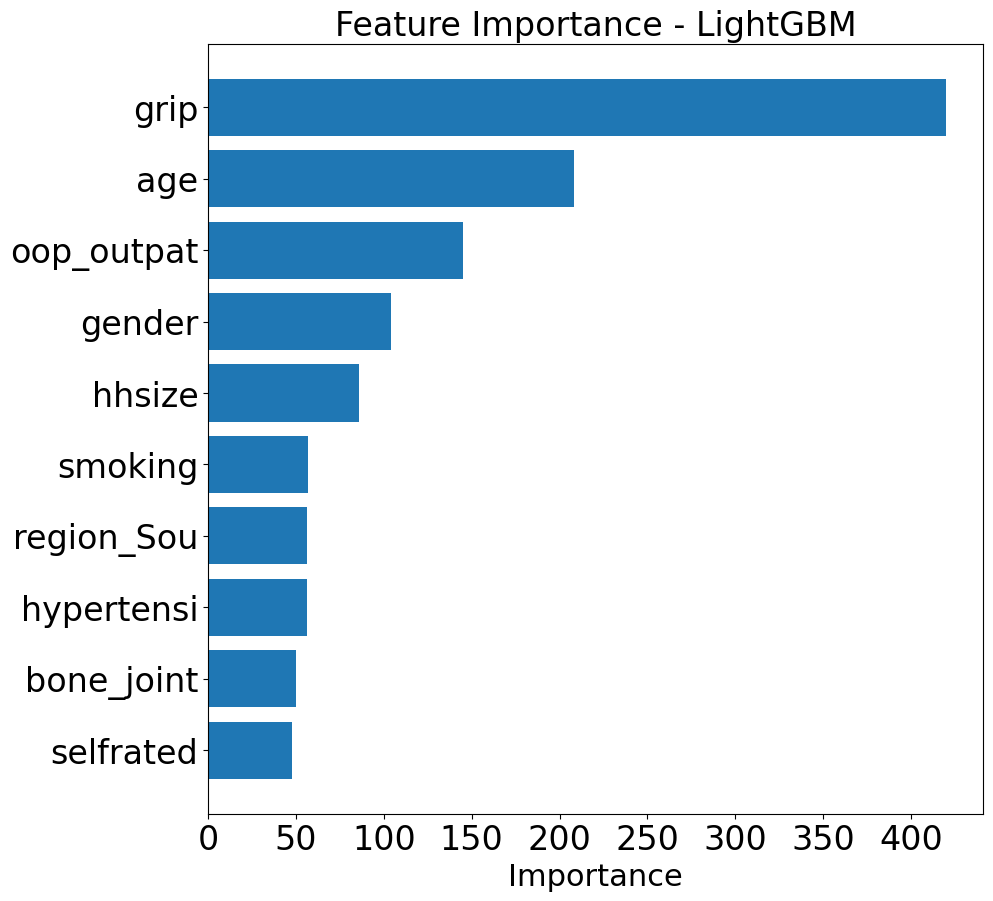

In [18]:
# Plot feature importance
feature_names = X_train.columns
# for model_name, model in final_models.items():
#     plot_feature_importance(model, model_name, feature_names, target_var)
plot_feature_importance(model_lgbm, 'LightGBM', feature_names, target_var)

# SHAP Summary Plot

In [ ]:
# Function: Calculate the confidence interval for the proportion
def plot_shap_summary(model, model_name, X_train, X_test, target_var):
    try:
        if model_name in ['Logistic Regression']: # , 'DNN', 'FCN'
            explainer = shap.Explainer(model, X_train)
            shap_values = explainer.shap_values(X_test)
        elif model_name in ['XGBoost', 'Gradient Boosting', 'LightGBM']:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
        else: # 'Random Forest'
            print(f'{model_name} is not supported')
            return

        # Save the SHAP values
        shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns)
        shap_values_df.to_csv(f'standardized\\{target_var}\\shap_values_{model_name}.csv', index=False)        
        
        # Summary Plot
        plt.figure()
        shap.summary_plot(shap_values, X_test, max_display=10, plot_type="layered_violin", show=False, color_bar=False)
        plt.title(f'Summary Plot - {model_name}', fontsize=20, pad=10)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        # Save the SHAP summary plot
        plt.savefig(f'standardized\\{target_var}\\fig\\shap_summary_{model_name}.png', pad_inches=0.1, bbox_inches='tight')
        plt.show()

        # # Bee Swarm Plot
        # plt.figure()
        # shap.summary_plot(shap_values, X_test, max_display=10, plot_type="dot", show=False)
        # plt.title(f'Bee Swarm Plot - {model_name}', fontsize=20, pad=10)
        # plt.xticks(fontsize=14)
        # plt.yticks(fontsize=18)
        # plt.tight_layout()
        # # Save the SHAP bee swarm plot
        # plt.savefig(f'{target_var}\\fig\\shap_beeswarm_{model_name}.png', pad_inches=0.1, bbox_inches='tight')
        # plt.show()

        # Bar Plot
        plt.figure()
        shap.summary_plot(shap_values, X_test, max_display=10, plot_type="bar", show=False)
        plt.title(f'Bar Plot - {model_name}', fontsize=20, pad=10)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=10)
        plt.tight_layout()
        # Save the SHAP bar plot
        plt.savefig(f'standardized\\{target_var}\\fig\\shap_bar_{model_name}.png', pad_inches=0.1, bbox_inches='tight')
        plt.show()

    except Exception as e:
        print(f"Error: {e}")

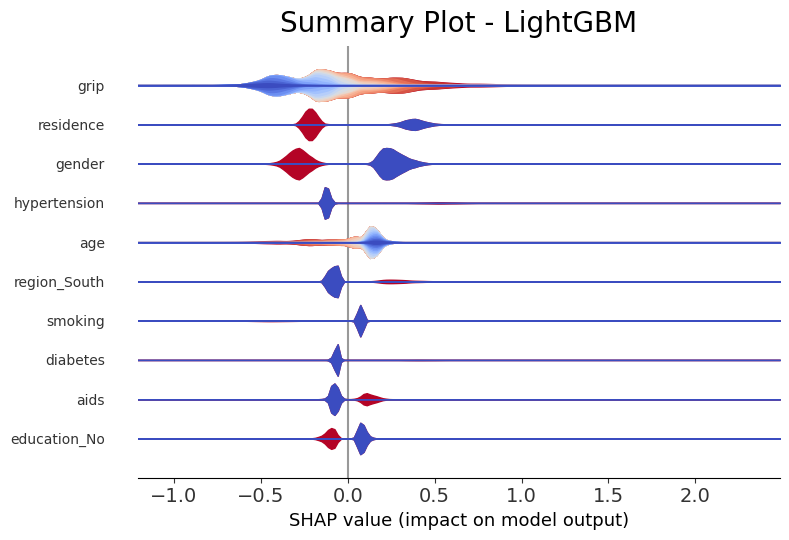

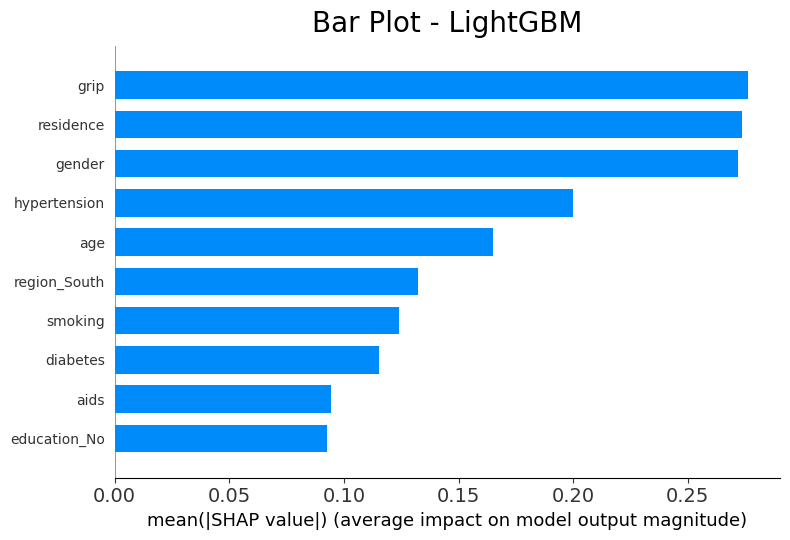

In [20]:
# Plot SHAP summary plot
# for model_name, model in final_models.items():
#     plot_shap_summary(model, model_name, X_train, X_test, target_var)
plot_shap_summary(model_lgbm, 'LightGBM', X_train, X_test, target_var)